# Training Set

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.externals import joblib
%matplotlib inline   

In [2]:
import os 
os.system('ps aux | grep wolfm2')
#os.system('killall -s SIGKILL -u wolfm2')
#os.system('cp /home/wolfm2/job.sh .; echo test 1>&2') #; cp ../job.log ../jerbb.txt')

0

### Read raw training data

In [3]:
amazon = pd.read_csv('/home/wolfm2/amazon_data/raw_data_train.csv')
print(amazon.shape)

(364000, 14)


In [34]:
print(amazon.head())
print(amazon['helpful'].mean())

    Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0       150581        487850  487851  B0025UCD76  A28B2M0XRXHXIG   
1       334018         21518   21519  B002QWP89S   A7JJX3KMDZD2F   
2        76657        319457  319458  B001GVIUX6  A2S8RJ6DRKGYON   
3       357903        248851  248852  B0009JRH1C  A1FLQ698D9C0C8   
4       301824        394613  394614  B001B4VOQI  A2KJO9EPX17ZXE   
5        59556        501110  501111  B000YVGMZW  A3LULJF2MQSAAQ   
6       365559        478948  478949  B001EQ52S4   AYTHZX0M3NFUS   
7       429018        555184  555185  B001VNKWD0  A2M069CN0QEW5N   
8       342078        458549  458550  B000FFIL92  A2UQY1VSFPNUGU   
9       250701         68227   68228  B003EM7J9Q  A28CGE4EOFSSDE   
10      190737        411661  411662  B001D6KH8K  A230CR2UUAURZE   
11      161823        428775  428776  B0053DJYOC   ALDI31TKPHP2R   
12      355008        419638  419639  B0029ZAOW8  A2IJAW6XZXETIA   
13      307044        119971  119972  B0002D9YIY

0.073206043956


### Feature extraction on natural language data

In [ ]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [5]:
import nltk
# nltk.download('punkt')
# nltk.download('popular')

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [ ]:
# vectorize Bag of Words from review text; as sparse matrix
from sklearn.feature_extraction.text import HashingVectorizer
#hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
#  analyzer=stemmed_words,

# look at the text tokenizer=LemmaTokenizer(), strip_accents=ascii,  stop_words={'english'}, 
hv0 = HashingVectorizer(n_features=2 ** 19, non_negative=True,
                           ngram_range=(1,4)) #, token_pattern = r'\b[a-zA-Z0-9]{3,}\b')
X_hv0 = hv0.fit_transform(amazon.Text) # mw adds uid as token

# # and a second domain where we look at the summary
# amazon['summaryFilter'] = amazon['Summary'].apply(lambda x: " " if x is np.nan else x) # some were np.nans
# hv1 = HashingVectorizer(n_features=2 ** 18, non_negative=True, strip_accents=ascii, tokenizer=LemmaTokenizer(), stop_words={'english'}, 
#                            ngram_range=(1,3), token_pattern = r'\b[a-zA-Z0-9]{3,}\b')
# X_hv1 = hv1.fit_transform(amazon.summaryFilter) 

# Another hash domain we want to count but not scale
# amazon['timeFilter'] = amazon['Time'].apply(lambda x: str(int(x)%(86400 * 7))) # converts to day of week
# hv2 = HashingVectorizer(n_features=2 ** 17, non_negative=True, strip_accents=ascii, 
#                            ngram_range=(1,1)) 
# X_hv2 = hv2.fit_transform(amazon.timeFilter + " " + amazon.ProductId + " " + amazon.UserId) # mw adds uid as token

amazon['ScoreX'] = amazon['Score'].apply(lambda x: str(x))) # converts to day of week
hv2 = HashingVectorizer(n_features=2 ** 17, non_negative=True, strip_accents=ascii, 
                           ngram_range=(1,1)) 
X_hv2 = hv2.fit_transform(amazon.ScoreX) # mw adds uid as token


# hv0 = HashingVectorizer(n_features=2 ** 17, non_negative=True)
# X_hv0 = hv0.fit_transform(amazon.ProductId + " " + amazon.UserId + " " + amazon.Text) # mw adds uid as token

# amazon['summaryFilter'] = amazon['Summary'].apply(lambda x: " " if x is np.nan else x) # some were np.nans

# hv1 = HashingVectorizer(n_features=2 ** 17, non_negative=True)
# X_hv1 = hv1.fit_transform(amazon.summaryFilter)

#import scipy.sparse as sp
#X_hv = sp.hstack([X_hv0, X_hv1], format='csr')
X_hv = X_hv0
print(X_hv.shape)

In [8]:
# x = amazon.UserId + " " +  amazon.Text
# x.head(10)

0    A28B2M0XRXHXIG This BBQ sauce is DELICIOUS!!  ...
1    A7JJX3KMDZD2F I gave a pet dog plural resembla...
2    A2S8RJ6DRKGYON I tried this in place of Iams. ...
3    A1FLQ698D9C0C8 Weight Loss Benefits of Green T...
4    A2KJO9EPX17ZXE Yes, they are a bit expensive b...
5    A3LULJF2MQSAAQ I was hungry and picked up a ca...
6    AYTHZX0M3NFUS I absolutely adore this stuff. I...
7    A2M069CN0QEW5N Now THIS is real cinnamon! Wond...
8    A2UQY1VSFPNUGU I am disappointed with this pur...
9    A28CGE4EOFSSDE What an awesome snack, super ea...
dtype: object

In [5]:
# We want to be able to use this model fit on other data (the test set)
# So let's save a copy of this instance of HashingVectorizer to be able to transform other data with this fit
# http://scikit-learn.org/stable/modules/model_persistence.html
joblib.dump(hv0, 'hv0.pkl') # pickle
# joblib.dump(hv1, 'hv1.pkl') # pickle
joblib.dump(hv2, 'hv2.pkl') # pickle

['hv.pkl']

In [6]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X_hv)

joblib.dump(transformer, 'transformer.pkl') # pickle

['transformer.pkl']

In [7]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [9]:
# features from Amazon.csv to add to feature set
#amazon['reviewLen'] = amazon['Text'].str.len()
#amazon['summaryLen'] = amazon['summaryFilter'].str.len()

#amazon['rlMeanDist'] = amazon['reviewLen'].apply(lambda x: abs(x-80)) # 80 is avg summary len. Thx George!
#amazon['slMeanDist'] = amazon['summaryLen'].apply(lambda x: abs(x-8)) # 8. just guessing here.

#import zlib
#amazon['nameHash'] = zlib.crc32(str(amazon['UserId']).encode('utf8'))
#amazon['nameHash'] = amazon['UserId'].apply(lambda x: zlib.crc32(str(x).encode('utf8'))) # bad. don't do it this way

# X_quant_features = amazon[["Score", "reviewLen", "summaryLen", "rlMeanDist", "slMeanDist"]]
# print(X_quant_features.head(10))
# print(type(X_quant_features))
X_quant_features = amazon[[]]

   Score  reviewLen
0      5        110
1      5        140
2      2        471
3      5      10800
4      5        152
5      4        231
6      5        271
7      5        320
8      2        362
9      5        283
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [ ]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr, X_hv2])  # we dont want to penalize hv2 w tfidf MW
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

### Create `X`, scaled matrix of features

In [10]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X = sc.fit_transform(X_matrix)
print(X.shape)

joblib.dump(sc, 'sc.pkl') # pickle

(364000, 131074)


['sc.pkl']

### create `y`, vector of Labels

In [11]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### fit models

In [12]:
from my_measures import BinaryClassificationPerformance

In [13]:
# # MODEL: SVM, linear
# from sklearn import linear_model
# svm = linear_model.SGDClassifier()
# svm.fit(X, y)
# joblib.dump(svm, 'svm.pkl') # pickle

# svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
# svm_performance.compute_measures()
# print(svm_performance.performance_measures)

/Users/aaronhill/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


{'Pos': 26582, 'Neg': 337418, 'TP': 11850, 'TN': 325157, 'FP': 12261, 'FN': 14732, 'Accuracy': 0.92584340659340658, 'Precision': 0.49147691924847581, 'Recall': 0.44579038447069447, 'desc': 'svm'}


In [14]:
# # MODEL: logistic regression
# from sklearn import linear_model
# #lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
# lgs = linear_model.SGDClassifier(loss='log', n_iter=1000, alpha=0.1)

# lgs.fit(X, y)
# joblib.dump(lgs, 'lgs.pkl') # pickle

# lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
# lgs_performance.compute_measures()
# print(lgs_performance.performance_measures)

/Users/aaronhill/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


{'Pos': 26582, 'Neg': 337418, 'TP': 13479, 'TN': 324641, 'FP': 12777, 'FN': 13103, 'Accuracy': 0.92890109890109895, 'Precision': 0.51336837294332727, 'Recall': 0.50707245504476717, 'desc': 'lgs'}


In [15]:
# # MODEL: Naive Bayes
# from sklearn.naive_bayes import MultinomialNB
# nbs = MultinomialNB()
# nbs.fit(X, y)
# joblib.dump(nbs, 'nbs.pkl') # pickle

# nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
# nbs_performance.compute_measures()
# print(nbs_performance.performance_measures)

{'Pos': 26582, 'Neg': 337418, 'TP': 17202, 'TN': 295255, 'FP': 42163, 'FN': 9380, 'Accuracy': 0.85839835164835165, 'Precision': 0.28976669754906087, 'Recall': 0.64712963659619294, 'desc': 'nbs'}


In [16]:
# # MODEL: Ridge Regression Classifier
# from sklearn import linear_model
# rdg = linear_model.RidgeClassifier()
# rdg.fit(X, y)
# joblib.dump(rdg, 'rdg.pkl') # pickle

# rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
# rdg_performance.compute_measures()
# print(rdg_performance.performance_measures)

{'Pos': 26582, 'Neg': 337418, 'TP': 7923, 'TN': 336780, 'FP': 638, 'FN': 18659, 'Accuracy': 0.94698626373626371, 'Precision': 0.92547599579488382, 'Recall': 0.29805883680686179, 'desc': 'rdg'}


In [17]:
# # MODEL: Perceptron
# from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron')
# prc.fit(X, y)
# joblib.dump(prc, 'prc.pkl') # pickle

# prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
# prc_performance.compute_measures()
# print(prc_performance.performance_measures)

/Users/aaronhill/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


{'Pos': 26582, 'Neg': 337418, 'TP': 11895, 'TN': 323880, 'FP': 13538, 'FN': 14687, 'Accuracy': 0.92245879120879126, 'Precision': 0.46769944560217042, 'Recall': 0.44748325934843125, 'desc': 'prc'}


In [ ]:
import json
import datetime
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB

from sklearn.neural_network import MLPClassifier # mw

# prepare a range of alpha values to test
# alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
alphas = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0.00001])
Cs = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
# create and fit a ridge regression model, testing each alpha
# model = linear_model.SGDClassifier(loss='perceptron', max_iter=50) # max_iter 1000

mlp = MLPClassifier(random_state=0)
svm = linear_model.SGDClassifier(n_iter=500)
lgs = linear_model.SGDClassifier(loss='log', n_iter=500)
nbs = MultinomialNB()
rdg = linear_model.RidgeClassifier()
prc = linear_model.SGDClassifier(loss='perceptron', n_iter=500)

for model in [[svm,"svm"], [lgs,"lgs"], [prc,"prc"], [nbs,"nbs"], [rdg,"rdg"]]: 
# for model in []: 
# for model in [rdg]:    
  fh = open("GridSearch.txt", "a")
  grid = GridSearchCV(estimator=model[0], param_grid=dict(alpha=alphas), n_jobs=2) #
  grid.fit(X, y)
  print(grid)
  # summarize the results of the grid search
  print(grid.cv_results_)
  print(grid.best_score_)
  print(grid.best_estimator_.alpha)

  fh.write('\n########\n')
  fh.write(str(datetime.datetime.now()))
  fh.write('\n########\n')
  fh.write(str(model[0]) + '\n')  
  fh.write(str(grid.cv_results_).replace(", '", ",\n'") + '\n')
  fh.write(str(grid.best_score_) + '\n')  
  fh.write(str(grid.best_estimator_.alpha) + '\n')
  fh.close()

  # MODEL: BEST
  best = grid.best_estimator_

  best.fit(X, y)
  joblib.dump(best, 'best.{}.pkl'.format(model[1])) # pickle

  best_performance = BinaryClassificationPerformance(best.predict(X), y, 'best')
  best_performance.compute_measures()
  print(best_performance.performance_measures)
  

In [ ]:
'''
pg = {'learning_rate': ["constant", "invscaling", "adaptive"],
'hidden_layer_sizes': [(100,1), (100,2), (100,3)],
#'alpha': [10.0 ** -np.arange(1, 7)],
'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
'activation': ["logistic", "relu", "Tanh"],
'tol': [1e-2, 1e-4, 1e-6],
'epsilon': [1e-3, 1e-7, 1e-8, 1e-9, 1e-8]
}

fh = open("GridSearch.txt", "a")
grid = GridSearchCV(estimator=mlp, param_grid=pg, n_jobs=2) #
grid.fit(X, y)
print(grid)
# summarize the results of the grid search
print(grid.cv_results_)
print(grid.best_score_)
print(grid.best_estimator_.alpha)

fh.write('\n########\n')
fh.write(str(datetime.datetime.now()))
fh.write('\n########\n')
fh.write(str(model) + '\n')  
fh.write(str(grid.cv_results_).replace(", '", ",\n'") + '\n')
fh.write(str(grid.best_score_) + '\n')  
fh.write(str(grid.best_estimator_.alpha) + '\n')
fh.close()
'''

In [ ]:
'''
# MODEL: BEST
best = grid.best_estimator_

best.fit(X, y)
joblib.dump(best, 'best.pkl') # pickle

best_performance = BinaryClassificationPerformance(best.predict(X), y, 'best')
best_performance.compute_measures()
print(best_performance.performance_measures)
'''

### ROC plot to compare performance of various models and fits

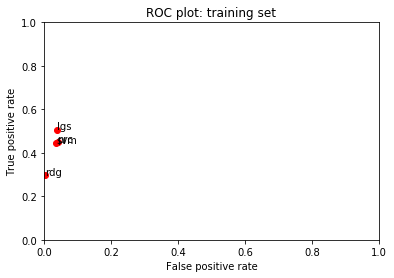

In [18]:
# #fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance]
# fits = [svm_performance, lgs_performance, rdg_performance, prc_performance]

# for fit in fits:
#     plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
#     plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
# plt.axis([0, 1, 0, 1])
# plt.title('ROC plot: training set')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.show()